## *Historical and Sociocultural Analysis of the Impact of World Events on Film Genre Trends*

 This project will explore historical trends in film genres, analyzing how societal and historical events—such as wars, economic shifts, and cultural influences—affect the popularity of genres. 
 It will also examine the impact of culture and globalization on global film production. The goal is to understand how historical events and cultural dynamics shape film genre trends over time and understand how periods of conflict, economic upheaval, or stability shape audience preferences and genre popularity.

In [144]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import seaborn as sns
from src.utils.appendix import *
from sklearn.preprocessing import MultiLabelBinarizer 
import geopandas as gpd
import plotly.graph_objects as go
from IPython.display import Image
from statsmodels.formula.api import ols
import pingouin as pg
from scipy.stats import kruskal
from scipy.stats import shapiro
%load_ext autoreload
%autoreload 2
from src.utils.data_cleaning2 import *
from src.utils.visualization import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Movies Dataset

For this part of the notebook we will use the movie dataset provided. We cleaned it and then preprocessed it for our project. We will then focus on some keys columns that will be useful for our project: Notamment les genres des movies and the countries involved in the production. 

In [145]:
raw_movies_data = pd.read_csv("data/MoviesDataset/movie.metadata.zip", header= None, delimiter='\t')
clean_movies_data = preprocess_movies(raw_movies_data)
processed_data_path = 'data/Preprocessed_data/preprocessed_movie_metadata.csv'
clean_movies_data.to_csv(processed_data_path, encoding='utf-8', errors='ignore', index=False)

In [146]:
preprocessed_movies = pd.read_csv(processed_data_path)
preprocessed_movies.head(2)

,Movie name,Movie box office revenue,Movie runtime,Languages,Countries,Genres,Year
0,Ghosts of Mars,14010832.0,98.0,English,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...",2001
1,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,English,United States of America,"Mystery, Biographical film, Drama, Crime Drama",2000


## RAJOUTER EDA 

### ➔ Preliminary Study - War Movies and WWII

In this section, we’ll conduct a brief analysis of movies classified as "War Movies." This is a straightforward, focused genre analysis over time, where we’ll examine trends in war movie production, particularly to see if there was an increase in production around major wartime periods, such as the World Wars.

Total number of War movies: 2467
Total number of War-Comedy movies: 225
Total number of War-Drama movies: 1656


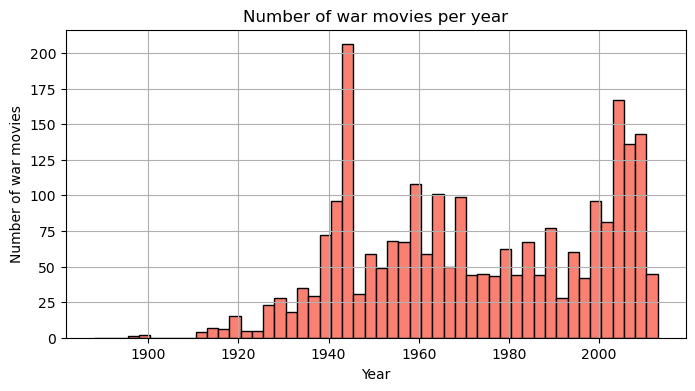

In [147]:
War_movies = preprocessed_movies[preprocessed_movies['Genres'].str.contains(r'war', case=False, na=False)]
War_movies_comedy = War_movies[War_movies['Genres'].str.contains(r'comedy', case=False, na=False)]
War_movies_drama = War_movies[War_movies['Genres'].str.contains(r'drama', case=False, na=False)]

print(f"Total number of War movies: {len(War_movies)}")
print(f"Total number of War-Comedy movies: {len(War_movies_comedy)}")
print(f"Total number of War-Drama movies: {len(War_movies_drama)}")

plt.figure(figsize=(8,4))
War_movies["Year"].hist(bins=50, range=(preprocessed_movies["Year"].min(), preprocessed_movies["Year"].max()), color = 'salmon', edgecolor = 'black')

plt.xlabel("Year")
plt.ylabel("Number of war movies")
plt.title("Number of war movies per year")
plt.show()


The plot shows the number of war movies produced each year. There is a significant increase in war movie production during the 1940s, which aligns with World War II, suggesting that the conflict likely influenced the film industry. Another peak appears around the early 2000s.

We know that the distribution of the movies is skewed to the right, so let's focus on the proportion rather than the number of movies.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


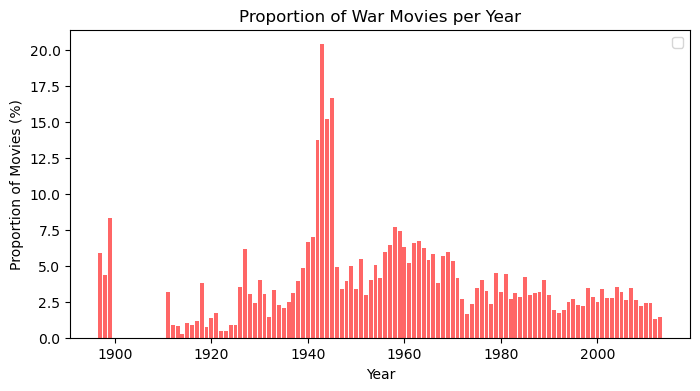

In [148]:
total_movies_per_year = preprocessed_movies.groupby('Year').size()
war_movies_per_year = War_movies.groupby('Year').size()

#proportion of each category of movie per year
war_movies_proportion = (war_movies_per_year / total_movies_per_year)*100
plot_bar(war_movies_proportion.index, war_movies_proportion.values, 'Year', 'Proportion of Movies (%)', 'Proportion of War Movies per Year')


The graph suggests a strong association of war movie production with the World War II era, where the genre’s prominence reached a historical high. We will test if these increasing is netherless statisticall significatif.

### **Hypothesis testing**

Null Hypothesis (H0): The proportion of war-themed movies is not significantly different before, during, and after World War II. In other words, WWII had no measurable effect on the trend in war movie production.

Alternative Hypothesis (H1): The proportion of war-themed movies increased significantly as a result of World War II or in the years immediately following it.

In [149]:
before_world_war_2 = War_movies[War_movies['Year'].between(1930, 1940)]
#As WWI start in september 1939 we will consider the start at 1940
during_word_war_2 = War_movies[War_movies['Year'].between(1940,1945)]
after_world_war_2 = War_movies[War_movies['Year'].between(1946,1970)]        

# Calculate the proportion of war movies before, during, and after World War II
before_world_war_2_proportion = (before_world_war_2.groupby('Year').size() / total_movies_per_year.loc[before_world_war_2['Year'].unique()]) * 100
during_world_war_2_proportion = (during_word_war_2.groupby('Year').size() / total_movies_per_year.loc[during_word_war_2['Year'].unique()]) * 100
after_world_war_2_proportion = (after_world_war_2.groupby('Year').size() / total_movies_per_year.loc[after_world_war_2['Year'].unique()]) * 100


print(f"Proportion of war movies before World War II: {before_world_war_2_proportion.mean():.2f}%")
print(f"Proportion of war movies during World War II: {during_world_war_2_proportion.mean():.2f}%")
print(f"Proportion of war movies after World War II: {after_world_war_2_proportion.mean():.2f}%")


Proportion of war movies before World War II: 3.39%
Proportion of war movies during World War II: 13.26%
Proportion of war movies after World War II: 5.31%


--> we need to test for normality of the data. Based on the result we could decide to run a parametric or non parametric statistica test

In [150]:
#Check normality of the before WWII movies
proportions = before_world_war_2_proportion.values
stat, p = shapiro(proportions)
print("During WWII p-value:", p)

# '' WWII movies
proportions = during_world_war_2_proportion.values
stat, p = shapiro(during_world_war_2_proportion)
print("During WWII p-value:", p)

# '' post WWII movies
proportions = after_world_war_2_proportion.values
stat, p = shapiro(after_world_war_2_proportion)
print("After WWII p-value:", p)

During WWII p-value: 0.4348604452879873
During WWII p-value: 0.4533458891237172
After WWII p-value: 0.7265481252739794


All the p_values are above 0.05. The data do not significantly deviate from a normal distribution. The test does not provide evidence that the data are non-normal so we will use a parametric test.

In [151]:
all_values = pd.concat([
    pd.DataFrame({'Proportion': before_world_war_2_proportion, 'Group': 'Before'}),
    pd.DataFrame({'Proportion': during_world_war_2_proportion, 'Group': 'During'}),
    pd.DataFrame({'Proportion': after_world_war_2_proportion, 'Group': 'After'})
])

# One-Way ANOVA
model = ols('Proportion ~ Group', data=all_values).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Check if ANOVA is significant
if anova_table['PR(>F)'][0] < 0.05:
    print("There is a significant difference between at least one pair of groups.")

    # Perform Tukey HSD post-hoc test to see which pairs differ
    posthoc = pg.pairwise_tukey(data=all_values, dv='Proportion', between='Group')
    print(posthoc)
else:
    print("There is no significant difference between the proportions of war movies before, during, and after World War II.")

             sum_sq    df          F        PR(>F)
Group     403.11952   2.0  37.733647  7.611535e-10
Residual  208.32417  39.0        NaN           NaN
There is a significant difference between at least one pair of groups.
        A       B   mean(A)    mean(B)      diff        se         T  \
0   After  Before  5.312585   3.387713  1.924873  0.836224  2.301863   
1   After  During  5.312585  13.261465 -7.948880  1.050686 -7.565422   
2  Before  During  3.387713  13.261465 -9.873752  1.172978 -8.417676   

        p-tukey    hedges  
0  6.735853e-02  1.425051  
1  1.082463e-08 -3.045361  
2  7.901886e-10 -2.784296  


C:\Users\lucil\AppData\Local\Temp\ipykernel_11632\1206508313.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_table['PR(>F)'][0] < 0.05:


The ANOVA revealed a significant difference in the proportions of war movies across the Before, During, and After WWII periods. Post-hoc testing showed that the During WWII period had a significantly higher proportion of war movies compared to both Before and After WWII. However, the difference between Before and After WWII was not statistically significant at the 5% level. This indicates that WWII was a unique period with a notable spike in war movie production, while the proportions returned closer to pre-war levels afterward.

We will introduce dummy variables to represent the WWII and post-WWII periods.
Then, we will fit a linear regression model with these variables to quantify their impact.
This approach allows us to see if the war years significantly shifted the baseline trend in war movie proportions.

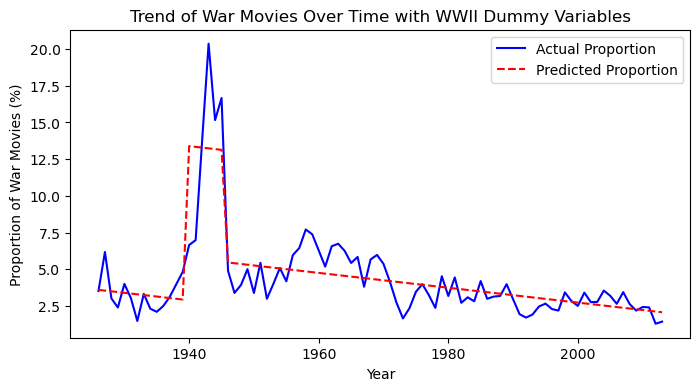

Intercept: 101.06850398202823
Coefficients (Year, During_WWII, After_WWII): [-0.05061055 10.50394973  2.87679344]


In [153]:
from sklearn.linear_model import LinearRegression

# Convert series to a DataFrame
war_movies = war_movies_proportion.to_frame(name='Proportion')
war_movies = war_movies.reset_index()
war_movies = war_movies[war_movies['Year'] > 1925]

# Create dummy variables
war_movies['During_WWII'] = ((war_movies['Year'] >= 1940) & (war_movies['Year'] <= 1945)).astype(int)
war_movies['After_WWII'] = (war_movies['Year'] >= 1946).astype(int)

# Prepare the data
X = war_movies[['Year', 'During_WWII', 'After_WWII']]
y = war_movies['Proportion'].values

# Remove NaN values if any
mask = ~np.isnan(y)
X = X[mask]
y = y[mask]

# Fit the linear regression model with multiple predictors
model = LinearRegression()
model.fit(X, y)

# Predict the proportions
predicted_proportions = model.predict(X)

# Plot the actual vs predicted proportions
plt.figure(figsize=(8, 4))
plt.plot(war_movies['Year'][mask], y, label='Actual Proportion', color='blue')
plt.plot(war_movies['Year'][mask], predicted_proportions, label='Predicted Proportion', color='red', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Proportion of War Movies (%)')
plt.title('Trend of War Movies Over Time with WWII Dummy Variables')
plt.legend()
plt.show()

# Print the model coefficients
print("Intercept:", model.intercept_)
print("Coefficients (Year, During_WWII, After_WWII):", model.coef_)


The equation of the linear regression model is: 
$$
War movie proportion=100.4728−(0.05×Year) + (10.50×During WWII) +(2.87×After WWII)
$$

- Year Coefficient (-0.05): A slight downward trend in war movie proportion over time, independent of WWII effects.

- During_WWII (10.50): During WWII, the proportion increases significantly above the baseline, suggesting a strong wartime influence on war movie production.

- After_WWII (2.87): Post-war, the proportion remains somewhat elevated, indicating that even after the war, the level of war movies doesn’t revert fully to the pre-war baseline.

The fitted model shows a distinct jump in the predicted war movie proportions during WWII and a recalibrated level afterward, indicating that the war era fundamentally changed the landscape of war film production. Although the model cannot perfectly recreate the actual dramatic spike, the presence of significant dummy variable effects strongly suggests that WWII had a measurable, lasting influence on the proportion of war movies produced.

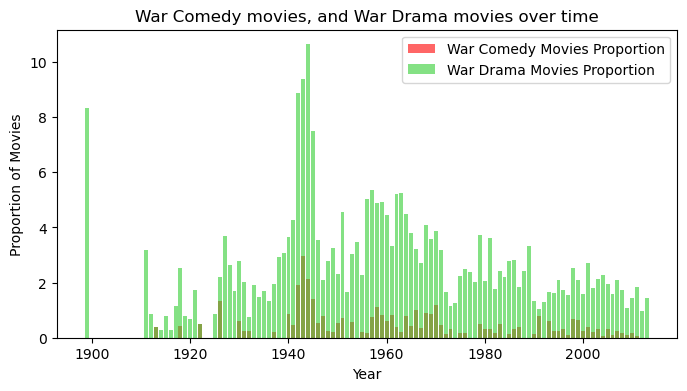

In [152]:
war_comedy_movies_per_year = War_movies_comedy.groupby('Year').size()
war_drama_movies_per_year = War_movies_drama.groupby('Year').size()

#calculate the proportion of each category of movie per year
war_comedy_movies_proportion = (war_comedy_movies_per_year / total_movies_per_year)*100
war_drama_movies_proportion = (war_drama_movies_per_year / total_movies_per_year)*100

plt.figure(figsize=(8, 4))
plt.bar(war_comedy_movies_proportion.index, war_comedy_movies_proportion.values, label='War Comedy Movies Proportion', color='red', alpha=0.6)
plt.bar(war_drama_movies_proportion.index, war_drama_movies_proportion.values, label='War Drama Movies Proportion', color='limegreen', alpha=0.6)

plt.xlabel('Year')
plt.ylabel('Proportion of Movies')
plt.title('War Comedy movies, and War Drama movies over time')
plt.legend(loc='upper right')
plt.show()

The graph clearly shows that the theme of war is much more frequently portrayed from a dramatic rather than a comedic perspective.

We aim to expand our analysis beyond just war movies and WWII. To do this, we will focus on selecting a few genres and events for our study. We will first explore the Genre column and then examine a new dataset for the events.

## MOVIES GENRES

In this section, we will examine how movies are classified into genres. Carefully analyzing, selecting and refining these genre classifications is essential for obtaining meaningful insights. 
We will discuss our approach to selecting and adjusting genres for our following study. 

In [7]:
#Number of genres in the dataset but we can see that there are a lot of categories that could be combined
genres = preprocessed_movies['Genres'].str.split(', ').explode().unique()

print(f"There are {len(genres)} genres in the dataset")

There are 362 genres in the dataset


In [ ]:
#print(f"Genres in the dataset are: {genres}")

Genres in the dataset are: ['Thriller' 'Science Fiction' 'Horror' 'Adventure' 'Supernatural' 'Action'
 'Space western' 'Mystery' 'Biographical film' 'Drama' 'Crime Drama'
 'Crime Fiction' 'Erotic thriller' 'Psychological thriller' 'Short Film'
 'Silent film' 'Indie' 'Black-and-white' 'Comedy' 'Family Film' 'Fantasy'
 'World cinema' 'Musical' 'Japanese Movies' 'Action/Adventure'
 'Romantic comedy' 'Ensemble Film' 'Comedy-drama' 'Romantic drama'
 'Romance Film' 'Costume drama' 'War film' 'Epic' 'Period piece'
 'Film adaptation' "Children's/Family" "Children's Fantasy" 'Future noir'
 'Comedy film' 'Coming of age' 'Suspense' 'Crime Thriller' 'Black comedy'
 'Bollywood' 'Marriage Drama' 'Wuxia' 'Martial Arts Film' 'Chinese Movies'
 'Western' 'Parody' 'Mockumentary' 'Fan film' 'Cult' 'Adventure Comedy'
 'Slapstick' 'Biopic [feature]' 'Historical Epic' 'Sports' 'Family Drama'
 'Political drama' 'Historical fiction' 'Courtroom Drama'
 'Culture & Society' 'Biography' 'Documentary' 'Christmas mo

Movies are classified into a wide variety of genres that reflect themes, styles, cultural contexts, narrative forms, or settings. However, not all of these dimensions are directly relevant to our analysis, so it is necessary to select genres that enable meaningful grouping of films.

There are several approaches we could take to group movies:
1. Select the most popular genres.
2. Identify correlations between genres to consolidate them into broader categories.
3. Manually select the genres most relevant to our analysis.

We will explore the first two options, and if they prove insufficient, we will resort to the third approach, which remains feasible given that manually handling 300 genres is manageable.

#### 1) Most Popular Genre

Number of genres assigned to more than 50 movies: 196.


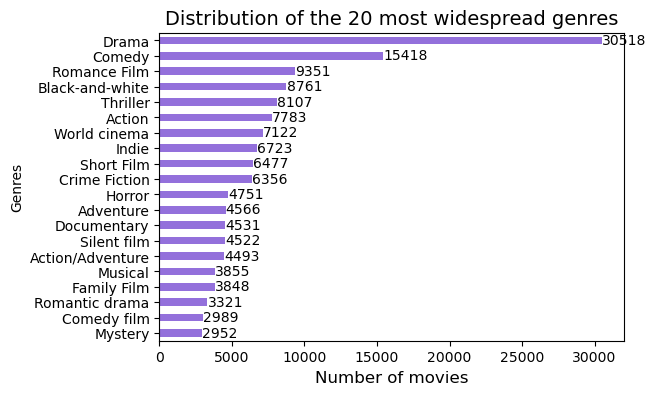

Genres
Drama               30518
Comedy              15418
Romance Film         9351
Black-and-white      8761
Thriller             8107
Action               7783
World cinema         7122
Indie                6723
Short Film           6477
Crime Fiction        6356
Horror               4751
Adventure            4566
Documentary          4531
Silent film          4522
Action/Adventure     4493
Musical              3855
Family Film          3848
Romantic drama       3321
Comedy film          2989
Mystery              2952
Name: count, dtype: int64


In [9]:
genres_counts = preprocessed_movies['Genres'].str.split(', ').explode().value_counts()

#Only keep genres that have been assigned to more than 50 movies
threshold = 50
relevant_genres = genres_counts[genres_counts > threshold]
print(f"Number of genres assigned to more than {threshold} movies: {len(relevant_genres)}.")

#20 most widespread genres
top_20_genres = relevant_genres.head(20)

plt.figure(figsize=(6, 4))
top_20_genres.plot(kind='barh', color='#9370DB')
plt.xlabel('Number of movies', fontsize=12)
plt.title('Distribution of the 20 most widespread genres', fontsize=14)
plt.gca().invert_yaxis() 

for index, value in enumerate(top_20_genres):
    plt.text(value + 10, index, str(value), va='center')
plt.show()

print(top_20_genres)

Many genres in the dataset may not be meaningful for our analysis because they contain very few movies, making it difficult to observe any trends over time for these genres. To focus on relevant genres, we can set an arbitrary threshold for the minimum number of movies assigned to each genre.

We also reviewed the top 20 genres to examine their distribution and identify which ones might be significant.

One immediate observation is that the genres are not inherently comparable, as they often describe entirely different aspects of a film. For example, comparing trends between "Black-and-White Film" and "Comedy" is problematic. The former describes a technical characteristic, while the latter defines the tone or mood of a film, and these categories are not mutually exclusive. A film can be both a black-and-white film and a comedy simultaneously. 

### 2) Correlation Between Genres

Based on the genre names alone, we can anticipate that certain genres might be correlated, appearing together frequently in movies. To explore these relationships, we’ll create a heatmap to visualize genre associations and identify any genres that are commonly paired in films.

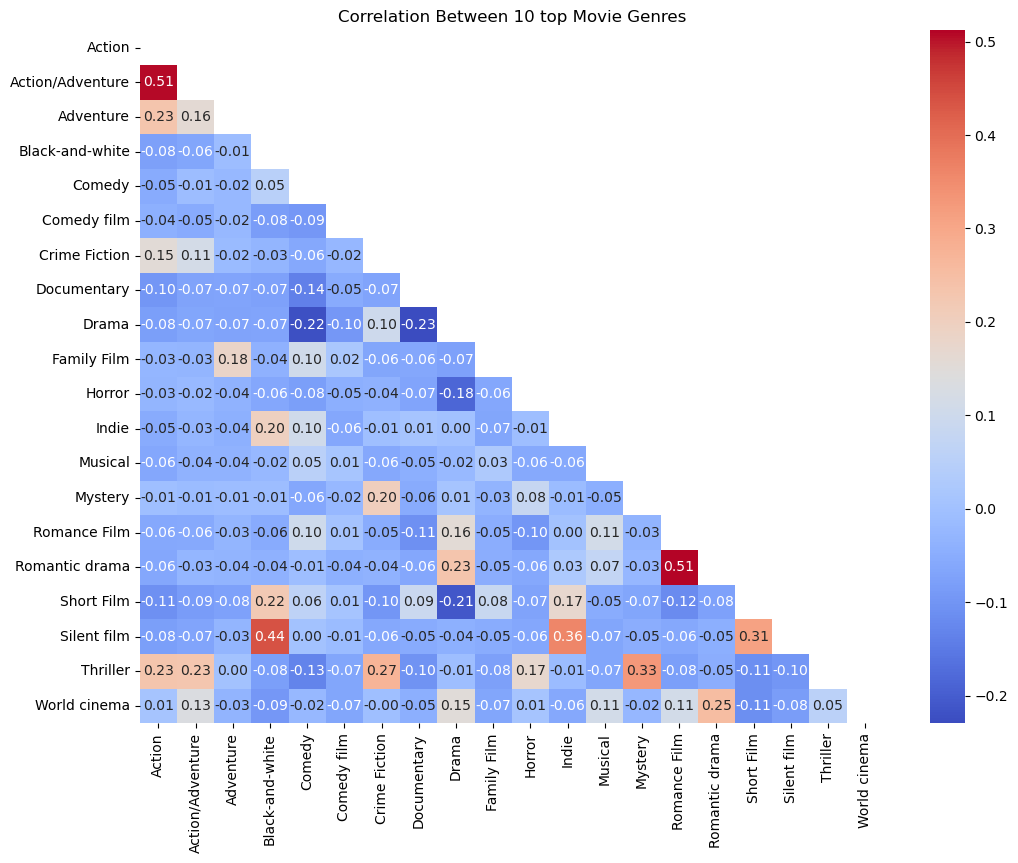

In [10]:
genre_movies = preprocessed_movies['Genres'].str.split(', ').explode()
genre_counts = genre_movies.value_counts().reset_index()
genre_counts.columns = ['Genres', 'Count']

genre_counts_top_20 = genre_counts.iloc[:20]
most_20commongenres,coverage20 = most_common_genres(preprocessed_movies, genre_counts_top_20, 20)
most_20commongenres = most_20commongenres.dropna(subset=['Genres'])

#Tranform the multi label genre of each movie into a binary matrix where each column represent a genre and each row a movie. If the movie is classified into the genre the value is 1 otherwise it is 0
mlb = MultiLabelBinarizer()

genre_binary_matrix = pd.DataFrame(mlb.fit_transform(most_20commongenres['Genres'].str.split(', ')), columns=mlb.classes_, index=most_20commongenres.index)
genre_correlation = genre_binary_matrix.corr()

plt.figure(figsize=(12, 9))
mask = np.triu(np.ones_like(genre_correlation, dtype=bool))
sns.heatmap(genre_correlation, mask=mask, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Between 10 top Movie Genres')
plt.show()

This heatmap illustrates how frequently two genres are used together to describe the same movie.

For example, the combination of "Crime Fiction" and "Thriller" shows a moderate positive correlation (0.26), suggesting that these genres often co-occur, meaning that movies labeled as "Crime Fiction" frequently include elements of "Thriller" as well. However, this co-occurrence is only moderately consistent across the dataset.

On the other hand, "Drama" and "Documentary" have a strong negative correlation (-0.28), indicating that these genres are rarely used together. This suggests that movies classified as "Drama" are typically not labeled as "Documentary" and vice versa.

We also observe some logical correlations between genres. For example, "Romance Film" has a strong correlation (0.50) with "Romantic Drama," and "Thriller" is correlated with "Crime Thriller" (0.43). This reflects how closely related these genre classifications are.

Ideally, a "Crime Thriller" would always be classified as a "Thriller," so the correlation should be 1. However, since movies are sometimes labeled with just one of these terms, we see a lower correlation. This suggests potential inconsistencies in labeling, where similar genres are named differently or only partially.

One solution might be to group genres with similar names. However, it’s not always straightforward. For example, if we consider "Romantic Drama" and "Romantic Comedy," should both be grouped under "Romance"? Or should one go under "Drama" and the other under "Comedy"? Alternatively, should each be classified in both "Romance" and their respective sub-genres ("Drama" or "Comedy")? The choice of grouping depends on how we want to structure the genre hierarchy and whether we aim to capture both overarching themes and specific sub-genres.

### 3) Manually select relevant genre

--> SELECT MANUALLY 

--> SEE TREND OVERTIME

--> SEE IF IT IS STATISTICALLY SIGNIFICANT. 

If we think it is link to an event, we can use a statistical test (which one is to determines) to see if it is really the event that has an impact on the number of movies released or is it for example juste time or external event

## --> To extend our analysis to more than one historical event we will use an extradataset of historical event